# Quantum Teleportation Algorithm

### Suppose that two parties, say Alice and Bob, want to exhcange a quantum state, e.g., a single qubit. Due to the no-cloning theorem in quantum mechanics, Bob cannot simply copy Alice's qubit state. Nonetheless, a "transfer" is still possible by taking advantage of an entangled state, shared by the two parties, and using a transmission of classical bits. In the end, Bob will have the quantum state Alice wanted to send, whereas she won't anymore, which is why this protocol is referred to as quantum "teleportation".

In [1]:
# import the necessary libraries
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

### We set up the quantum circuit for this protocol. It will consist of 3 qubits and two classical registers containing 1 bit each. Qubits $q_0$ and $q_1$ will represent the ones carried by Alice, and $q_2$ - Bob's qubit. Alice wants to send the state of qubit $q_0$ to Bob. Qubits $q_1$ and $q_2$ are part of the entangled pair which will be used to make this happen.

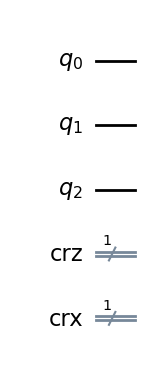

In [7]:
quantum_register = QuantumRegister(3, name='q')
classical_regsiter_0 = ClassicalRegister(1, name='crz')
classical_regsiter_1 = ClassicalRegister(1, name='crx')
teleporation_circuit = QuantumCircuit(quantum_register, classical_regsiter_0, classical_regsiter_1)
display(teleporation_circuit.draw(output='mpl'))

### The entangled pair shared by Alice and Bob through qubits $q_1$ and $q_2$ is the Bell state $$\ket{q_2q_1} = \frac{1}{\sqrt{2}}\left(\ket{00}+ \ket{11}\right).$$ We add the appropriate gates to create this state to the circuit.

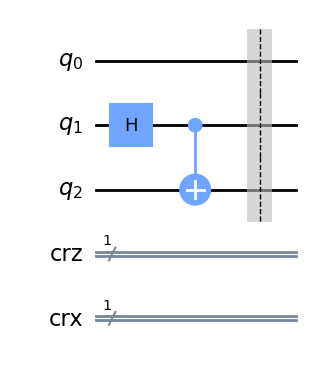

In [8]:
teleporation_circuit.h(1)
teleporation_circuit.cx(1, 2)
teleporation_circuit.barrier()
display(teleporation_circuit.draw(output='mpl'))

### In order to transfer the state in qubit $q_0$ to Bob, which is say in the general state $$\ket{q_0} = a\ket{0} + b\ket{1},$$ Alice has to perform the following two operations on her qubits:
 - ### Apply a control-NOT gate with $q_0$ as the control qubit, and $q_1$ as the target. The overall $3$-qubit state initially is: $$\ket{q_2q_1q_0} = \frac{1}{\sqrt{2}}\left(\ket{00}+ \ket{11}\right)\left(a\ket{0} + b\ket{1}\right) = \frac{a}{\sqrt{2}}\ket{000} + \frac{a}{\sqrt{2}}\ket{110} + \frac{b}{\sqrt{2}}\ket{001} + \frac{b}{\sqrt{2}}\ket{111},$$ and after the step it becomes: $$\ket{q_2q_1q_0} = \frac{a}{\sqrt{2}}\ket{000} + \frac{a}{\sqrt{2}}\ket{110} + \frac{b}{\sqrt{2}}\ket{011} + \frac{b}{\sqrt{2}}\ket{101}.$$
 - ### Apply a Hadamard transform to qubit $q_0$. The overall state now becomes: $$\ket{q_2q_1q_0} = \frac{a}{2}\ket{000} + \frac{a}{2}\ket{001} + \frac{a}{2}\ket{110} + \frac{a}{2}\ket{111} + \frac{b}{2}\ket{010} - \frac{b}{2}\ket{011} + \frac{b}{2}\ket{100} - \frac{b}{2}\ket{101}.$$

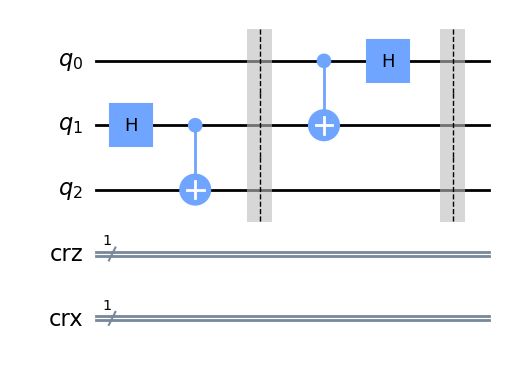

In [9]:
# add Alice's steps as gates in circuit
teleporation_circuit.cx(0, 1)
teleporation_circuit.h(0)
teleporation_circuit.barrier()
display(teleporation_circuit.draw(output='mpl'))

### After applying the tranformations to her qubits, Alice measures their state and stores in the two classical registers. These are then sent to Bob.

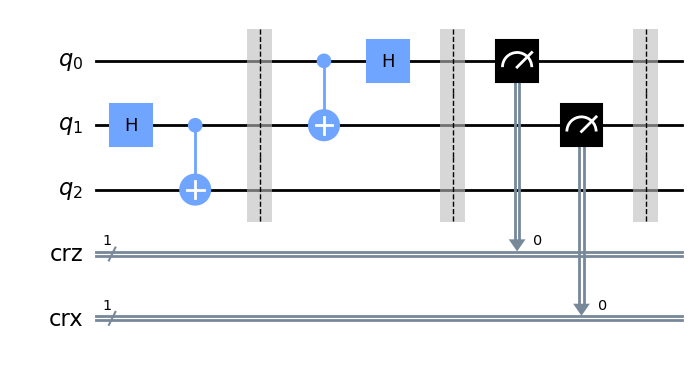

In [10]:
# Alice performs a measurement of her qubits
teleporation_circuit.measure([0, 1], [0, 1])
teleporation_circuit.barrier()
display(teleporation_circuit.draw(output='mpl'))

### Once Bob has the two bits, he can perform tranformations to his qubit in order to recover the state $q_0$ was in initially. The 4 different cases are:
- ### Bob has received the bit-string '00'. This means that Alice has measured the state $\ket{q_1q_0} = \ket{00}$, which happens with probability $\frac{|a|^2 + |b|^2}{4} = \frac{1}{4}$, and so the overall state has collapsed such that qubit $q_2$ is now in state $$\ket{q_2} = a\ket{0} + b\ket{1}.$$ This is exactly the initial state of $q_0$ so Bob shouldn't apply any gates.
- ### Bob has received the bit-string '01'. This means that Alice has measured the state $\ket{q_1q_0} = \ket{01}$, which happens with probability $\frac{|a|^2 + |b|^2}{4} = \frac{1}{4}$, and so the overall state has collapsed such that qubit $q_2$ is now in state $$\ket{q_2} = a\ket{0} - b\ket{1}.$$ Bob must apply a $Z$ gate to recover the initial state.
- ### Bob has received the bit-string '10'. This means that Alice has measured the state $\ket{q_1q_0} = \ket{10}$, which happens with probability $\frac{|a|^2 + |b|^2}{4} = \frac{1}{4}$, and so the overall state has collapsed such that qubit $q_2$ is now in state $$\ket{q_2} = a\ket{1} + b\ket{0}.$$ Bob must apply an $X$ gate to recover the initial state.
- ### Bob has received the bit-string '11'. This means that Alice has measured the state $\ket{q_1q_0} = \ket{11}$, which happens with probability $\frac{|a|^2 + |b|^2}{4} = \frac{1}{4}$, and so the overall state has collapsed such that qubit $q_2$ is now in state $$\ket{q_2} = a\ket{1} - b\ket{0}.$$ Bob must apply an $X$ gate, followed by a $Z$ gate to recover the initial state.

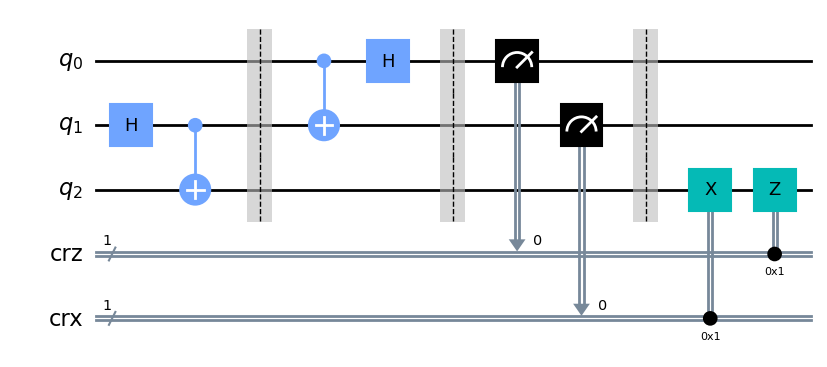

In [11]:
# add the conditional gates applied by Bob to recover the initial quantum state
teleporation_circuit.x(2).c_if(classical_regsiter_1, 1)
teleporation_circuit.z(2).c_if(classical_regsiter_0, 1)
display(teleporation_circuit.draw(output='mpl'))

### We now test the teleportation protocol to make sure it works correctly. To do this, we will randomly generate a single qubit state which Alice wants to send to Bob. This will be done through some initial gate applied to $q_0$. At the end of the protocol we will apply the inverse of that gate to $q_2$ and measure the outcome. If the protocol works correctly, we should always measure $\ket{q_2} = \ket{0}$.

State Alice wants to send:


<IPython.core.display.Latex object>

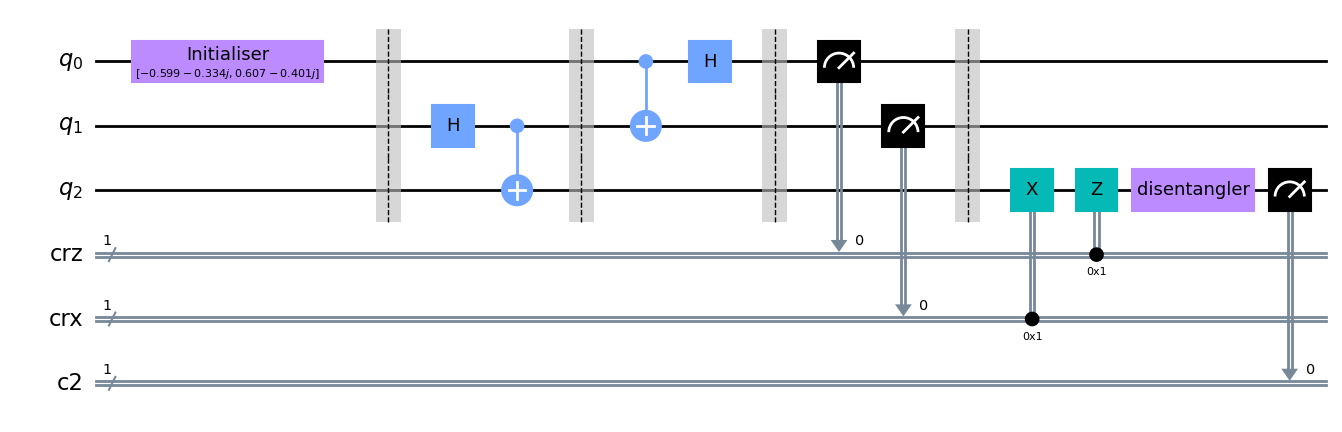

In [26]:
initial_state = random_statevector(2)
print("State Alice wants to send:")
display(initial_state.draw(output='latex'))

# create gate which transforms |0> state to desired initial state
initialiser = Initialize(initial_state)
initialiser.label = "Initialiser"

# create the inverse gate
disentangler = initialiser.gates_to_uncompute()
disentangler.label = "Disentangler"

# build the full quantum circuit
quantum_register = QuantumRegister(3, name='q')
classical_regsiter_0 = ClassicalRegister(1, name='crz')
classical_regsiter_1 = ClassicalRegister(1, name='crx')
teleporation_circuit = QuantumCircuit(quantum_register, classical_regsiter_0, classical_regsiter_1)

teleporation_circuit.append(initialiser, [0])
teleporation_circuit.barrier()

teleporation_circuit.h(1)
teleporation_circuit.cx(1, 2)
teleporation_circuit.barrier()

teleporation_circuit.cx(0, 1)
teleporation_circuit.h(0)
teleporation_circuit.barrier()

teleporation_circuit.measure([0, 1], [0, 1])
teleporation_circuit.barrier()

teleporation_circuit.x(2).c_if(classical_regsiter_1, 1)
teleporation_circuit.z(2).c_if(classical_regsiter_0, 1)

teleporation_circuit.append(disentangler, [2])
bob_measurement = ClassicalRegister(1)
teleporation_circuit.add_register(bob_measurement)
teleporation_circuit.measure([2], [2])

display(teleporation_circuit.draw(output='mpl'))




/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


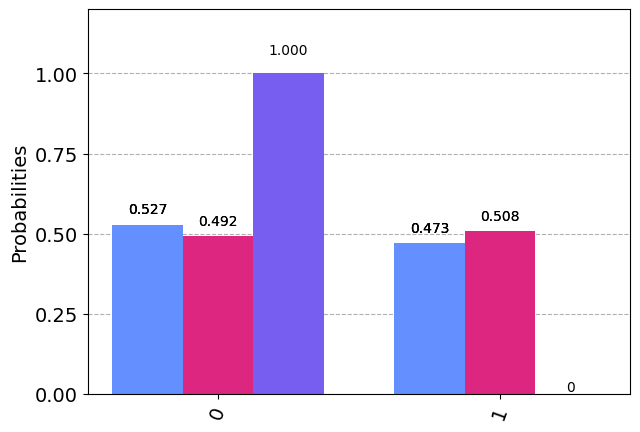

In [29]:
# run the quantum circuit on a simulator
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(teleporation_circuit, simulator)
result = simulator.run(transpiled_circuit).result()
counts = result.get_counts()
counts_per_qubit = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(counts_per_qubit)

### We see that there is a $100\%$ probability that we measure Bob's qubit in state $\ket{0}$, meaning that the teleportation has been successful. Additionally, note that the probability of measuring Alice's qubits in any of the computational bases states is completely random, so she does not have access to the state she sent anymore, as is required by the no-cloning theorem.